# Code for fitting DATA = a*QCD + b*VBF
## Diego Baron

First, import the plotter and iminuit libraries. The second part creates a 2D least square fit.

In [55]:
# basic setup of the notebook
from matplotlib import pyplot as plt
import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
#from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)


############ Create a 2D least square fit ###################

from iminuit.util import describe, make_func_code
class LeastSquares:
    """
    Generic least-squares cost function with error.
    """

    errordef = Minuit.LEAST_SQUARES # for Minuit to compute errors correctly

    def __init__(self, model, s1, s2, y, err):
        self.model = model  # model predicts y for given x
        self.s1 = np.asarray(s1)
        self.s2 = np.asarray(s2)
        self.y = np.asarray(y)
        self.err = np.asarray(err)

    def __call__(self, *par):  # we accept a variable number of model parameters
        ym = self.model(self.s1,self.s2, *par)
        return np.sum((self.y - ym) ** 2 / self.err ** 2)
    
class BetterLeastSquares(LeastSquares):
    def __init__(self, model, s1 , s2, y, err):
        super().__init__(model, s1,s2 , y, err)
        self.func_code = make_func_code(describe(model)[2:])

iminuit version: 2.11.2


## Configuring the FIT

In [76]:
path_to_root_files = "/home/diego/HEP/VBF-Analysis/MuMu/Plots/ABCD-Mod/SR/"
histogram = "mass_jj"

QCD_sample = 'Zmumu_Average.root'
VBF_sample = 'Signal_Sherpa.root'

BG_samples = ['Wjets.root','singletop.root','VV.root','ttbar.root']
BG_Tau = ['Higgs.root','Zjets.root']
#BG_samples += BG_Tau

Unpack the histograms and plot the relevant shapes

In [77]:
import os
import ROOT as r
import ctypes
import pandas as pd
import numpy as np

def biner(edges,bin_widths,histogram):
    if (len(edges)+1!=len(bin_widths)):
        print("Check edges and bin widths array sizes!")
        return
    
    bins=[]
    first_bin = histogram.GetXaxis().GetBinLowEdge(1)
    print(first_bin)
    last_bin = histogram.GetXaxis().GetBinUpEdge(histogram.GetNbinsX())
    print(last_bin)
    for i in range(0,len(edges)):
        n_spaces = int((edges[i] - first_bin)/bin_widths[i])
        bins = np.concatenate((bins,np.linspace(first_bin,edges[i],n_spaces,endpoint=False)))
        first_bin = edges[i]
        if edges[i]==edges[-1]:
            n_spaces = int((last_bin - edges[i])/bin_widths[i+1])
            bins = np.concatenate((bins,np.linspace(edges[i],last_bin,n_spaces,endpoint=False)))
            bins = np.concatenate((bins,[last_bin]))
    return bins

def normalization(hist_list,norm_bin):
    for hist in hist_list:
        for i in range(1,hist.GetNbinsX()+1):
            value=hist.GetBinContent(i)
            error=hist.GetBinError(i)
            sf=hist.GetBinWidth(i)/norm_bin
            hist.SetBinContent(i,value/sf)
            hist.SetBinError(i,error/sf)
            
def Unpack_Histo(histogram_file):
    bin_content = []
    bin_content_uncer =[]
    for i in range(2,histogram_file.GetNbinsX()+1):
        bin_content.append(histogram_file.GetBinContent(i))
        bin_content_uncer.append(histogram_file.GetBinError(i))
    return np.array(bin_content),np.array(bin_content_uncer)

############# DATA SUBTRACTION #######################

#r.TH1.SetDefaultSumw2()

data_file = r.TFile.Open(path_to_root_files+'Data.root')
data_hist = data_file.Get(histogram)
data_hist.SetDirectory(0)

s=data_hist.GetXaxis().GetBinLowEdge(1)
e=data_hist.GetXaxis().GetBinUpEdge(data_hist.GetNbinsX())
rebining=biner([1500],[250,500],data_hist)
nb=len(rebining)-1
data_hist=data_hist.Rebin(nb,"data",rebining)


for i in BG_samples:
    file = r.TFile.Open(path_to_root_files+i)
    bg_sample = file.Get(histogram)
    bg_sample = bg_sample.Rebin(nb,"bg",rebining)
    data_hist.Add(bg_sample,-1)
    file.Close()

############# VBF AND QCD HISTOGRAM SET UP #########################

QCD_file = r.TFile.Open(path_to_root_files+QCD_sample)
QCD_hist = QCD_file.Get(histogram)
QCD_hist.SetDirectory(0)
QCD_hist=QCD_hist.Rebin(nb,"QCD",rebining)

VBF_file = r.TFile.Open(path_to_root_files+VBF_sample)
VBF_hist = VBF_file.Get(histogram)
VBF_hist.SetDirectory(0)
VBF_hist=VBF_hist.Rebin(nb,"VBF",rebining)

################### NORMALISING SHAPES #####################

normalization([data_hist,QCD_hist,VBF_hist],250)

############## UNPACKING THE HISTOGRAMS INTO NUMPY ARRAYS ################

data_shape, data_shape_uncer = Unpack_Histo(data_hist)
qcd_shape, qcd_shape_uncer = Unpack_Histo(QCD_hist)
vbf_shape, vbf_shape_uncer = Unpack_Histo(VBF_hist)

total_uncer = np.sqrt(data_shape_uncer**2+vbf_shape_uncer**2+qcd_shape_uncer**2)

x_bins = np.array([data_hist.GetBinLowEdge(i) for i in range(2,data_hist.GetNbinsX()+1)])

#data_shape[7]=vbf_shape[7]+qcd_shape[7]


index=0
for i in range(len(data_shape)):
    if data_shape[i]<0:
        break
    index+=1

def correct_shape(vector,index):
    return vector[0:index]

data_shape = correct_shape(data_shape,index)
qcd_shape = correct_shape(qcd_shape,index)
vbf_shape = correct_shape(vbf_shape,index)
data_shape_uncer = correct_shape(data_shape_uncer,index)
qcd_shape_uncer = correct_shape(qcd_shape_uncer,index)
vbf_shape_uncer = correct_shape(vbf_shape_uncer,index)
x_bins = correct_shape(x_bins,index)
total_uncer = correct_shape(total_uncer,index)

print("x = ",x_bins)
print("y = ",data_shape)
print("y_error = ",total_uncer)

0.0
5000.0
x =  [ 250.  500.  750. 1000. 1250. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]
y =  [5.67804639e+03 3.96238452e+03 1.94404895e+03 1.01440216e+03
 6.01668640e+02 2.72080719e+02 1.07836609e+02 5.42514839e+01
 2.49428005e+01 1.09567184e+01 6.98769569e+00 2.00000000e+00]
y_error =  [75.8041399  63.3614609  44.38373527 32.04674295 24.67682356 11.74405513
  7.39845961  5.24533936  3.554586    2.36134679  1.88013837  1.00949606]


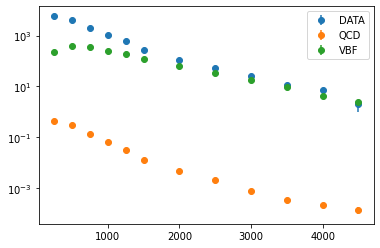

In [78]:

# our model, unicode parameter names are supported :)
def model(shape1,shape2, qcd, vbf):
    return qcd*shape1 + vbf*shape2


# generate random toy data with random offsets in y
x_axis = x_bins
y_axis = data_shape

### Normalise the mc samples

qcd_shape = qcd_shape/qcd_shape.sum()
#vbf_shape = vbf_shape/vbf_shape.sum()


y_error = total_uncer

# draw toy data
plt.errorbar(x_axis, y_axis,y_error, fmt="o",label='DATA');
plt.errorbar(x_axis, qcd_shape,qcd_shape_uncer, fmt="o",label='QCD');
plt.errorbar(x_axis, qcd_shape+vbf_shape,np.sqrt(vbf_shape_uncer**2+qcd_shape_uncer**2), fmt="o",label='VBF');
plt.legend()
plt.yscale("log")


## Perform the Fit

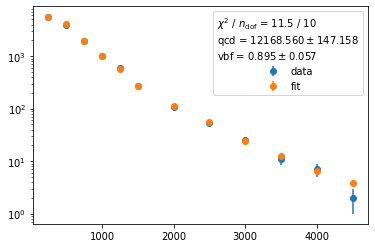

In [79]:
# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = BetterLeastSquares(model,qcd_shape,vbf_shape, data_shape,total_uncer)

m = Minuit(least_squares, qcd=1000.0, vbf=1.0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# draw data and fitted line
plt.errorbar(x_axis, data_shape, total_uncer, fmt="o", label="data")
plt.errorbar(x_axis, model(qcd_shape,vbf_shape, *m.values),0,fmt="o", label="fit")
plt.yscale('log')

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x_axis) - m.nfit}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info));

In [50]:
m.values

<ValueView qcd=9838.368864590011 vbf=1.3049959254135501>